# SAD representation

In this notebook we develop a representation of waterbodies by their SAD curves. For a particular waterbody there are lots of ways we can characterise it by SAD curves, depending on how we aggregate the time series data. So let's look at a few ways of characterising some waterbodies - a natural lake, an off-creek storage dam, a dammed lake, a regulated farm storage, a crop field, a monsoonal river, and a groundwater spring - and then use that knowledge to develop a representation.

## Load data

In [86]:
pip install palettable

Unload all python modules, if you experience any issues.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 111 kB 3.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [607]:
import geopandas as gpd
import h5py
import matplotlib
import numpy as np
import palettable
import pandas as pd
from matplotlib import pyplot as plt
import scipy.ndimage
from tqdm.notebook import tqdm

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8, 6)

In [13]:
waterbodies = gpd.read_file("waterbodies_joined_drainage_basins.shp").to_crs(
    "EPSG:3577"
)

In [14]:
waterbodies = waterbodies.set_index("UID", drop=False)

In [15]:
waterbodies.loc[pd.isnull(waterbodies.BNAME), "BNAME"] = "NONE"

In [16]:
history_file = h5py.File(
    "interpolated_waterbodies_by_division_and_basin_fixed.h5", mode="r"
)

In [17]:
dates = pd.to_datetime([l.decode("ascii") for l in history_file["dates"]])

## Calculate SADs for representative waterbodies

- Cowarra Dam, an off-creek storage dam (r6ksspxqv)
- Blue Lake, a glacial lake in Kosciuszko National Park (r392yuzdg)
- Lake Burley Griffin, a dammed lake not used for water (r3dp1nxh8)
- Lake Hume, a dammed lake used _extremely_ for water (r38dsrnum)
- A crop field in the MDB (r1zc2mjqr)
- A billabong near Albury (r385r7qx7)
- A farm storage near Moree (r6f29tp9t)
- The Mitchell River, which is very monsoonal (rjjkujrwt)
- The Murray River near Mildura, which is very regulated (r1vjj61zv)
- Copeton Dam, which is managed but rainfall-driven (r6emgd4fz)
- A groundwater-fed wetland (rhxnsrqkh)
- Another groundwater-fed system (rhxnkxwpv)
- A combination groundwater and monsoonal system (rhz5kng4j)

Note that the Cowarra Dam was only filled in 2005, and so makes an excellent case study for a well-behaved waterbody that may look unusual because it didn't exist. To get around this issue, we'll only look at the last 15 years of data.

In [482]:
uids = [
    "r6ksspxqv",
    "r392yuzdg",
    "r3dp1nxh8",
    "r38dsrnum",
    "r1zc2mjqr",
    "r385r7qx7",
    "r6f29tp9t",
    "rjjkujrwt",
    "r1vjj61zv",
    "r6emgd4fz",
    "rhxnsrqkh",
    "rhxnkxwpv",
    "rhz5kng4j",
]

In [483]:
names = [
    "Cowarra Dam",
    "Kosciuszko Blue Lake",
    "Lake Burley Griffin",
    "Lake Hume",
    "Crop field",
    "Billabong",
    "Farm storage",
    "Mitchell River",
    "Murray River",
    "Copeton Dam",
    "Groundwater wetland",
    "Groundwater",
    "Monsoonal groundwater",
]

In [484]:
wbs = waterbodies.loc[uids]

In [25]:
r = wbs.iloc[0]

In [59]:
history_file[r.Division_][r.BNAME]["pc_wet"].shape

(324, 12391)

In [65]:
(history_file[r.Division_][r.BNAME]["uid"][:].astype(str) == r.UID).shape

(324,)

In [73]:
ts = [
    (
        history_file[r.Division_][r.BNAME]["pc_wet"][
            history_file[r.Division_][r.BNAME]["uid"][:].astype(str) == r.Index, :
        ][0]
    )
    for r in wbs.itertuples()
]

In [524]:
last_fifteen_years = slice(-365 * 15, None)

In [529]:
sads = np.sort(np.array(ts)[:, last_fifteen_years], axis=1)[:, ::-1]

In [530]:
colours = (
    palettable.cartocolors.qualitative.Pastel_10.mpl_colors
    + palettable.cartocolors.qualitative.Antique_10.mpl_colors
)

In [531]:
def plot_sads(
    sads,
    ylabel="Total surface area (% of maximum extent)",
    xlabel="Duration (% of all time)",
    ax=None,
    yerr=None,
    label=True,
):
    if ax is None:
        fig, ax = plt.subplots()
    for i, (c, n, s, ls) in enumerate(
        zip(colours, names, sads, ["-."] * 10 + ["--"] * 10,)
    ):
        ax.plot(np.linspace(0, 100, len(s)), s, label=n, c=c, linestyle=ls)
        if yerr is not None:
            ax.fill_between(
                np.linspace(0, 100, len(s)),
                s - yerr[i],
                s + yerr[i],
                color=c,
                alpha=0.5,
            )

        x = int(10000 / 12300 * len(s))
        buffer = int(0.02 * x)

        if n == "Kosciuszko Blue Lake":
            x = int(7500 / 10000 * x)
        elif n == "Billabong":
            x = int(7500 / 10000 * x)
        elif n == "Groundwater":
            x = int(8000 / 10000 * x)
        elif n == "Farm storage":
            x = int(6070 / 10000 * x)
            buffer = 1
        elif n == "Crop field":
            x = int(3000 / 10000 * x)
        elif n == "Mitchell River":
            x = int(2500 / 10000 * x)

        xc = np.linspace(0, 100, len(s))[x]
        xl = np.linspace(0, 100, len(s))[x - buffer]
        xu = np.linspace(0, 100, len(s))[x + buffer]

        pos1 = ax.transData.transform_point((xl, s[x - buffer]))
        pos2 = ax.transData.transform_point((xu, s[x + buffer]))
        dy = pos2[1] - pos1[1]
        dx = pos2[0] - pos1[0]
        rot = np.rad2deg(np.arctan2(dy, dx))
        if label:
            ltex = ax.text(
                xc,
                s[x],
                n,
                size=8,
                rotation=rot,
                color=c,
                ha="center",
                va="center",
                bbox=dict(ec="1", fc="1"),
            )

    if not label:
        ax.legend()

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

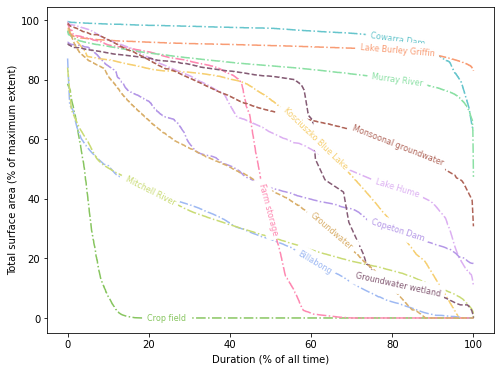

In [532]:
plot_sads(sads)

## Monthly and yearly aggregation

By aggregating the water levels differently we can make different SAD curves which are less sensitive to small-scale changes in surface area. We can also make different SAD curves by changing the amount of time considered. Let's do both of those.

By default, our aggregation is daily.

In [533]:
histories = pd.DataFrame(ts)

In [534]:
histories.index = names

In [535]:
histories = histories.T
histories.index = pd.DatetimeIndex(dates)

In [538]:
monthly_agg = histories[histories.index.year >= 2005].resample("M").mean()
yearly_agg = histories[histories.index.year >= 2005].resample("Y").mean()

In [539]:
monthly_agg_sads = np.sort(monthly_agg, axis=0)[::-1, :].T
yearly_agg_sads = np.sort(yearly_agg, axis=0)[::-1, :].T

Text(0.5, 1.0, 'Yearly aggregation')

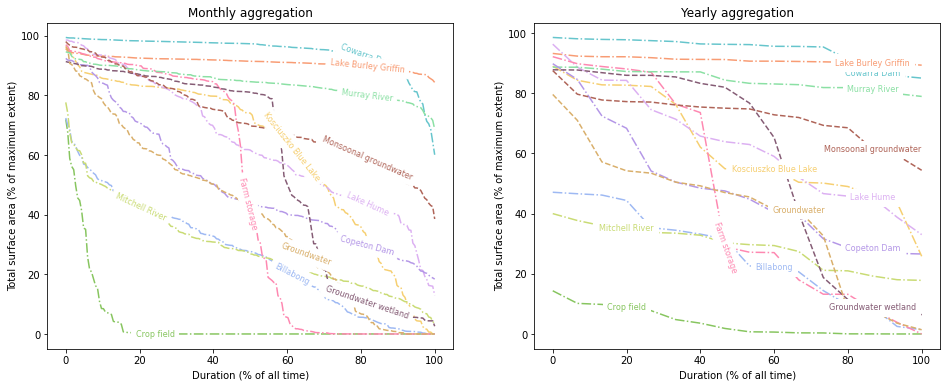

In [540]:
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(16, 6))
plot_sads(monthly_agg_sads, ax=ax_l)
ax_l.set_title("Monthly aggregation")
plot_sads(yearly_agg_sads, ax=ax_r)
ax_r.set_title("Yearly aggregation")

This aggregation mainly changes the resolution rather than the actual structure. That means that the SAD curve is mainly looking at long-time things.

But we can also aggregate the curves themselves: for each aggregation period (with overlap? without overlap? with filtering?), compute the SAD. Then average these. This should also give a standard deviation, which could be useful in itself. The way we choose the aggregation periods could matter a lot too. For example,

- aggregate each month then average over months,
- aggregate each month and only average January,
- aggregate with a rolling 30-day window...

We'll just look at the former for now for both yearly and three-monthly (monthly data vary too much to get meaningful results).

In [544]:
month_sads = []
for d, h in histories[histories.index.year >= 2005].groupby(pd.Grouper(freq="3M")):
    sad = np.sort(h, axis=0)[::-1]
    sad = [
        np.interp(np.linspace(0, 1, 31 * 3), np.linspace(0, 1, len(s)), s)
        for s in sad.T
    ]
    month_sads.append(sad)
month_sads_std = np.std(month_sads, axis=0)
month_sads = np.mean(month_sads, axis=0)

year_sads = []
for d, h in histories[histories.index.year >= 2005].groupby(pd.Grouper(freq="1Y")):
    sad = np.sort(h, axis=0)[::-1]
    sad = [
        np.interp(np.linspace(0, 1, 366), np.linspace(0, 1, len(s)), s) for s in sad.T
    ]
    year_sads.append(sad)
year_sads_std = np.std(year_sads, axis=0)
year_sads = np.mean(year_sads, axis=0)

Text(0.5, 1.0, 'Yearly mean')

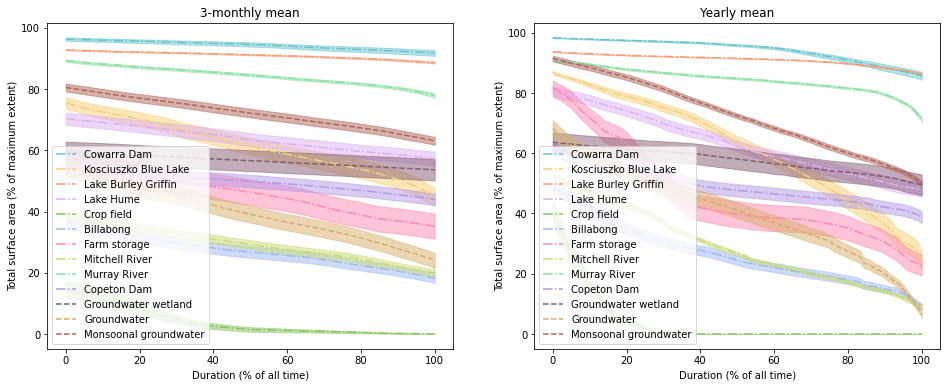

In [545]:
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(16, 6))
plot_sads(month_sads, ax=ax_l, yerr=month_sads_std / 10, label=False)
ax_l.set_title("3-monthly mean")
plot_sads(year_sads, ax=ax_r, yerr=year_sads_std / 10, label=False)
ax_r.set_title("Yearly mean")

## Seasonal filters

By only looking at a given season, we can see how the waterbody behaves in that season. Let's plot this for the four seasons.

In [546]:
seasons = {
    "summer": histories.index.month.isin({1, 2, 12}),
    "autumn": histories.index.month.isin({3, 4, 5}),
    "winter": histories.index.month.isin({6, 7, 8}),
    "spring": histories.index.month.isin({9, 10, 11}),
}

In [547]:
sads_seasonal["summer"].shape

(13, 3069)

In [550]:
sads_seasonal = {
    season: np.sort(histories[(histories.index.year >= 2005) & mask].T, axis=1)[:, ::-1]
    for season, mask in seasons.items()
}

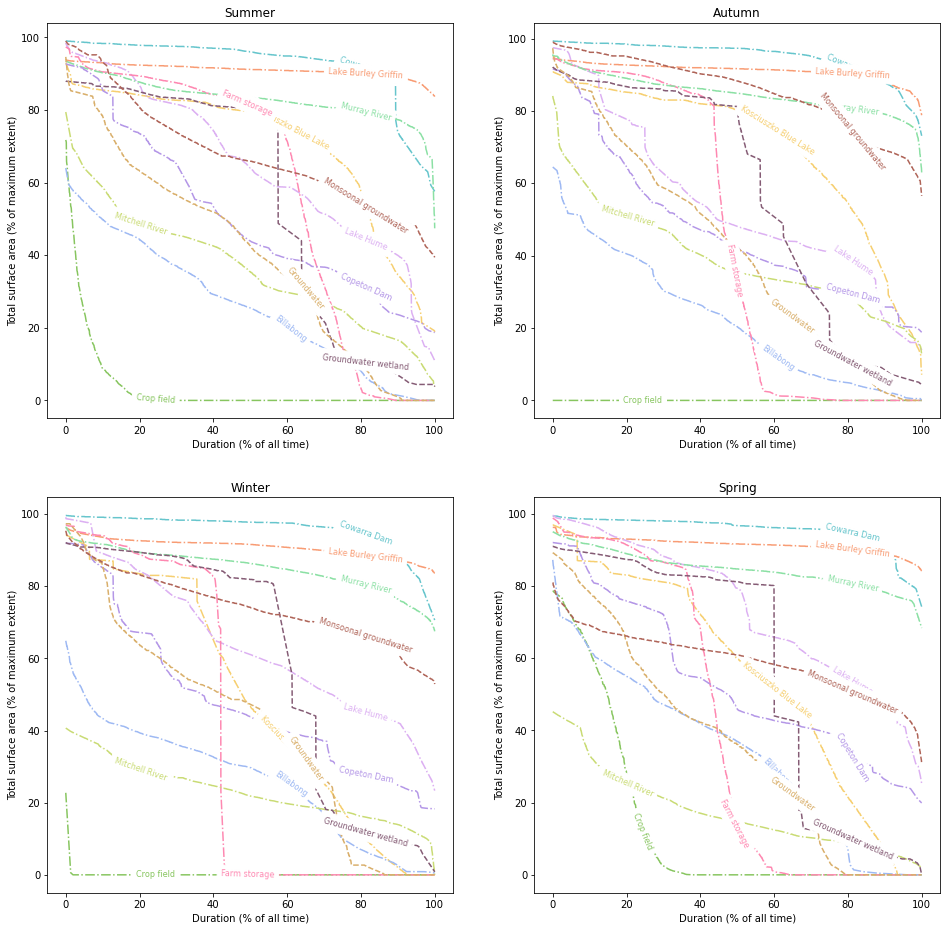

In [551]:
fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(16, 16))
for (season, sad), ax in zip(sads_seasonal.items(), [a, b, c, d]):
    plot_sads(sad, ax=ax)
    ax.set_title(season.title())

The between-season variability would also be really interesting. We could look at the difference between summer and winter for example:

In [552]:
aligned_seasonal = {
    season: np.array(
        [
            np.interp(np.linspace(0, 1, 3000), np.linspace(0, 1, len(s)), s)
            for s in sads_seasonal[season]
        ]
    )
    for season in sads_seasonal
}
summer_winter_diff = aligned_seasonal["summer"] - aligned_seasonal["winter"]

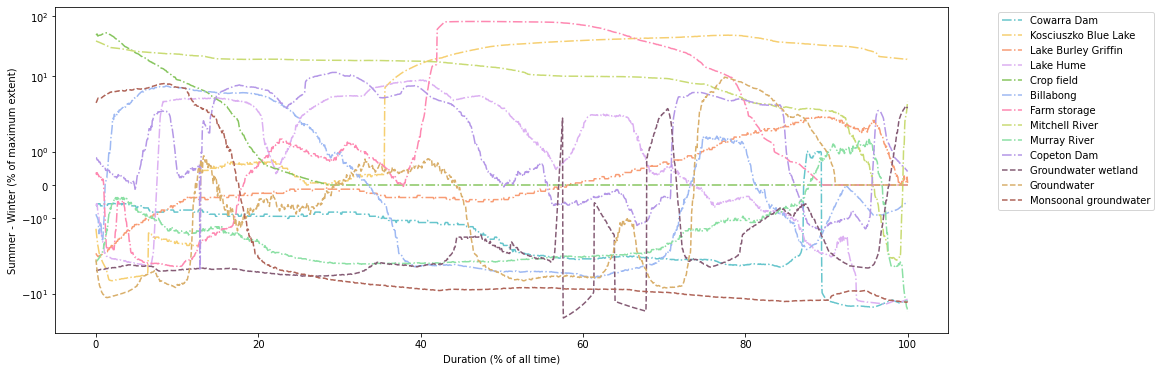

In [553]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_sads(
    summer_winter_diff,
    label=False,
    ax=ax,
    ylabel="Summer - Winter (% of maximum extent)",
)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.yscale("symlog")

## Representations

We will use:

- the deciles of the SAD curve,
- the gradients at the deciles,
- the deciles and gradients of the yearly average SAD,
- the variation of the deciles of the yearly SAD curve,
- the seasonal average deciles and gradients.

In [554]:
deciles = sads[:, np.linspace(0, sads.shape[1] - 1, 11).astype(int)]

In [555]:
# Smooth before taking the gradient to remove rapid variations.
grads = np.gradient(scipy.ndimage.gaussian_filter1d(sads.astype(float), 27, axis=1), axis=1)[:, np.linspace(1, sads.shape[1] - 1, 11).astype(int)]

In [556]:
avg_deciles = year_sads[:, np.linspace(0, year_sads.shape[1] - 1, 11).astype(int)]

In [557]:
avg_grads = np.gradient(scipy.ndimage.gaussian_filter1d(year_sads.astype(float), 7, axis=1), axis=1)[:, np.linspace(1, year_sads.shape[1] - 1, 11).astype(int)]

In [558]:
avg_variation = year_sads_std[:, np.linspace(0, year_sads_std.shape[1] - 1, 11).astype(int)]

In [564]:
seasonal_deciles = {
    season: s[:, np.linspace(0, s.shape[1] - 1, 11).astype(int)]
    for season, s in sads_seasonal.items()
}

seasonal_grads = {
    season: np.gradient(scipy.ndimage.gaussian_filter1d(s.astype(float), 7, axis=1), axis=1)[:, np.linspace(1, s.shape[1] - 1, 11).astype(int)]
    for season, s in sads_seasonal.items()
}

In [578]:
features = np.concatenate([
    deciles,
    grads,
    avg_deciles,
    avg_grads,
    avg_variation,
    seasonal_deciles['summer'],
    seasonal_deciles['autumn'],
    seasonal_deciles['winter'],
    seasonal_deciles['spring'],
    seasonal_grads['summer'],
    seasonal_grads['autumn'],
    seasonal_grads['winter'],
    seasonal_grads['spring'],
], axis=1)

In [583]:
assert features.shape[1] == 11 * 13

## Computing for all waterbodies

We will now compute these features for all waterbodies.

In [609]:
history_file.close()
history_file = h5py.File(
    "interpolated_waterbodies_by_division_and_basin_fixed.h5", mode="r+"
)

In [610]:
for division in tqdm(history_file):
    if division == 'dates':
        continue
    
    for basin in history_file[division]:
        history = history_file[division][basin]['pc_wet'][()]
        assert history.shape[1] == len(dates)
        
        # Regular SAD
        sads = np.sort(history[:, last_fifteen_years], axis=1)[:, ::-1]
        
        # Yearly average SAD
        ts = pd.DataFrame(history.T)
        ts.index = dates
        year_sads = []
        for d, h in ts[ts.index.year >= 2005].groupby(pd.Grouper(freq="1Y")):
            sad = np.sort(h, axis=0)[::-1]
            sad = [
                np.interp(np.linspace(0, 1, 366), np.linspace(0, 1, len(s)), s) for s in sad.T
            ]
            year_sads.append(sad)
        year_sads_std = np.std(year_sads, axis=0)
        year_sads = np.mean(year_sads, axis=0)
        
        # Seasonal SADs
        sads_seasonal = {
            season: np.sort(ts[(ts.index.year >= 2005) & mask].T, axis=1)[:, ::-1]
            for season, mask in seasons.items()
        }
        
        # Get the deciles and gradients
        deciles = sads[:, np.linspace(0, sads.shape[1] - 1, 11).astype(int)]
        # Smooth before taking the gradient to remove rapid variations.
        grads = np.gradient(scipy.ndimage.gaussian_filter1d(sads.astype(float), 27, axis=1), axis=1)[:, np.linspace(1, sads.shape[1] - 1, 11).astype(int)]
        avg_deciles = year_sads[:, np.linspace(0, year_sads.shape[1] - 1, 11).astype(int)]
        avg_grads = np.gradient(scipy.ndimage.gaussian_filter1d(year_sads.astype(float), 7, axis=1), axis=1)[:, np.linspace(1, year_sads.shape[1] - 1, 11).astype(int)]
        avg_variation = year_sads_std[:, np.linspace(0, year_sads_std.shape[1] - 1, 11).astype(int)]
        seasonal_deciles = {
            season: s[:, np.linspace(0, s.shape[1] - 1, 11).astype(int)]
            for season, s in sads_seasonal.items()
        }
        seasonal_grads = {
            season: np.gradient(scipy.ndimage.gaussian_filter1d(s.astype(float), 7, axis=1), axis=1)[:, np.linspace(1, s.shape[1] - 1, 11).astype(int)]
            for season, s in sads_seasonal.items()
        }
        
        features = np.concatenate([
            deciles,
            grads,
            avg_deciles,
            avg_grads,
            avg_variation,
            seasonal_deciles['summer'],
            seasonal_deciles['autumn'],
            seasonal_deciles['winter'],
            seasonal_deciles['spring'],
            seasonal_grads['summer'],
            seasonal_grads['autumn'],
            seasonal_grads['winter'],
            seasonal_grads['spring'],
        ], axis=1)
        assert features.shape[1] == 11 * 13
        assert features.shape[0] == len(history)
        ds = history_file[division][basin].require_dataset('sad_features', shape=features.shape, dtype='float32')
        ds[:, :] = features

In [611]:
history_file.close()